In [ ]:
# --- 1. Imports (เรียกไลบรารีที่จำเป็น) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# --- 2. Load Data  ---
file_path = 'UCI_Credit_Card.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: ไม่พบไฟล์ '{file_path}'")
    exit()

In [ ]:
# --- 3. Initial Setup  ---
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']

categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
numerical_features = [col for col in X.columns if col not in categorical_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train/Test split: {X_train.shape[0]} train, {X_test.shape[0]} test")

Train/Test split: 24000 train, 6000 test


In [ ]:
# --- 4. Preprocessing (เตรียมข้อมูลสำหรับ Keras) ---
# สร้าง Preprocessor
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Fitting preprocessor and transforming data...")
# Fit preprocessor บน X_train และแปลงทั้ง X_train และ X_test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ** สำคัญ **: Keras ทำงานได้ดีที่สุดกับ Dense Arrays (NumPy Arrays)
# เราจะแปลง Sparse Matrix ที่ได้จาก preprocessor ให้เป็น Dense Array
X_train_dense = X_train_processed.toarray()
X_test_dense = X_test_processed.toarray()

# เก็บจำนวน features ที่แปลงแล้ว (เช่น 91) เพื่อใช้ใน Input layer
n_features = X_train_dense.shape[1]
print(f"Preprocessing complete. Number of features: {n_features}")

Fitting preprocessor and transforming data...
Preprocessing complete. Number of features: 91


In [ ]:
# --- 5. Class Weighting (จัดการ Imbalance) ---
# คำนวณ Class Weight
# 'balanced' จะคำนวณน้ำหนักอัตโนมัติ (Class 0 ได้น้ำหนักน้อย, Class 1 ได้น้ำหนักมาก)
weights = compute_class_weight(class_weight='balanced', 
                             classes=np.unique(y_train), 
                             y=y_train)

class_weight_dict = {0: weights[0], 1: weights[1]}
print(f"Calculated Class Weights: {class_weight_dict}")

Calculated Class Weights: {0: np.float64(0.6420202236370446), 1: np.float64(2.2603126765869277)}


In [ ]:
# --- 6. Build the MLP Model  ---
model = Sequential(name="MLP_Credit_Risk_Model")

# Input Layer: ระบุ n_features
model.add(Input(shape=(n_features,), name="Input_Layer"))

# Hidden Layer 1: 64 neurons, 'relu' activation
model.add(Dense(128, activation='relu', name="Hidden_Layer_1"))
# Dropout (ป้องกัน Overfitting)
model.add(Dropout(0.3, name="Dropout_1"))

# Hidden Layer 2: 32 neurons
model.add(Dense(64, activation='relu', name="Hidden_Layer_2"))
model.add(Dropout(0.2, name="Dropout_2"))

model.add(Dense(32, activation='relu', name="Hidden_Layer_3"))
model.add(Dropout(0.2, name="Dropout_3"))

# Output Layer: 1 neuron, 'sigmoid' activation
# (Sigmoid ให้ผลลัพธ์เป็น Probability 0.0 ถึง 1.0)
model.add(Dense(1, activation='sigmoid', name="Output_Layer"))

# แสดงสรุปโครงสร้างโมเดล
model.summary()

Model: "MLP_Credit_Risk_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 128)            │        11,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,145 (86.50 KB)

 Trainable params: 22,145 (86.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 7. Compile the Model  ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        Precision(name='precision'), # เน้น Class 1
        Recall(name='recall'),       # เน้น Class 1
        AUC(name='auc')              # ตัววัดประสิทธิภาพโดยรวมที่ดีสำหรับ Imbalance
    ]
)

In [ ]:
# --- 8. Train the Model (ฝึกโมเดล) ---
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
print("\nTraining the model (this may take a minute)...")
history = model.fit(
    X_train_dense,       # ข้อมูล train ที่แปลงแล้ว
    y_train,             # เป้าหมาย train
    epochs=20,           # จำนวนรอบในการฝึก (เริ่มที่ 20 ก่อน)
    batch_size=128,      # ขนาดของข้อมูลที่ป้อนในแต่ละครั้ง
    
    # ** นี่คือหัวใจสำคัญ **: ส่ง Class Weight ที่คำนวณไว้เข้าไป
    class_weight=class_weight_dict,
    
    # ใช้ Test Set เป็น Validation Set เพื่อดูประสิทธิภาพระหว่างเทรน
    validation_data=(X_test_dense, y_test),
    callbacks=[early_stopping_callback]
)
print("Training complete!")


Training the model (this may take a minute)...
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7042 - auc: 0.7284 - loss: 0.6088 - precision: 0.3920 - recall: 0.6112 - val_accuracy: 0.7617 - val_auc: 0.7707 - val_loss: 0.5760 - val_precision: 0.4702 - val_recall: 0.6127
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7474 - auc: 0.7658 - loss: 0.5733 - precision: 0.4494 - recall: 0.6303 - val_accuracy: 0.7608 - val_auc: 0.7693 - val_loss: 0.5644 - val_precision: 0.4684 - val_recall: 0.6029
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7487 - auc: 0.7709 - loss: 0.5698 - precision: 0.4511 - recall: 0.6263 - val_accuracy: 0.7120 - val_auc: 0.7756 - val_loss: 0.5999 - val_precision: 0.4087 - val_recall: 0.6760
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7460 - auc: 0.7779 - loss: 0.5637 - precision: 0.4484 - recall: 0.6427 - val_accuracy: 0.7035 - val_auc: 0.7728 - val_loss: 0.6085 - val_precision: 0.4005 - val

In [ ]:
# --- 9. Evaluate the Model (ประเมินผล) ---
print("\n--- 9.1: Final Evaluation on Test Set ---")
# ประเมินผลลัพธ์สุดท้ายด้วย Test Set
final_metrics = model.evaluate(X_test_dense, y_test, verbose=0)
print(f"Test Loss: {final_metrics[0]:.4f}")
print(f"Test Accuracy: {final_metrics[1]:.4f}")
print(f"Test Precision: {final_metrics[2]:.4f}")
print(f"Test Recall: {final_metrics[3]:.4f}")
print(f"Test AUC: {final_metrics[4]:.4f}")


--- 9.1: Final Evaluation on Test Set ---
Test Loss: 0.5760
Test Accuracy: 0.7617
Test Precision: 0.4702
Test Recall: 0.6127
Test AUC: 0.7707


In [ ]:
# 9.2 สร้าง Classification Report (เพื่อเทียบ F1-Score)
print("\n--- 9.2: Classification Report (MLP) ---")
# 1. ทำนาย Probability
y_proba_mlp = model.predict(X_test_dense)
# 2. แปลง Probability เป็น Class (0 หรือ 1) โดยใช้เกณฑ์ 0.5
y_pred_mlp = (y_proba_mlp > 0.5).astype(int)
# 3. แสดง Report
print(classification_report(y_test, y_pred_mlp, target_names=['Not Default (0)', 'Default (1)']))
print("Baseline F1-Score (Class 1) to beat: 0.52")


--- 9.2: Classification Report (MLP) ---
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
                 precision    recall  f1-score   support

Not Default (0)       0.88      0.80      0.84      4673
    Default (1)       0.47      0.61      0.53      1327

       accuracy                           0.76      6000
      macro avg       0.67      0.71      0.69      6000
   weighted avg       0.79      0.76      0.77      6000

Baseline F1-Score (Class 1) to beat: 0.52



--- 9.3: Plotting Training History ---


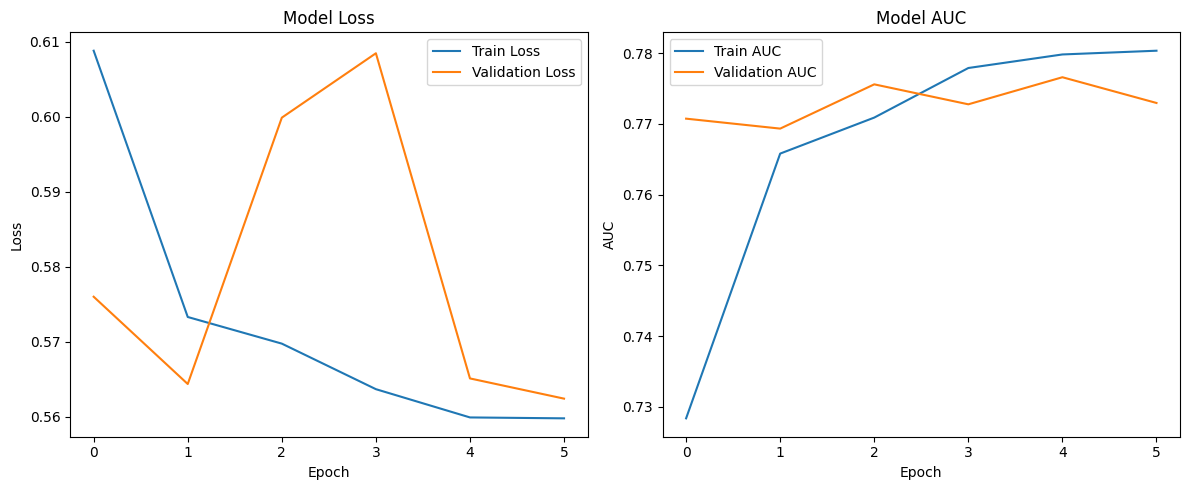

In [ ]:
# 9.3 พล็อตกราฟ Training History (Loss)
print("\n--- 9.3: Plotting Training History ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# 9.4 พล็อตกราฟ Training History (AUC)
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


--- 9.4: Confusion Matrix (MLP) ---


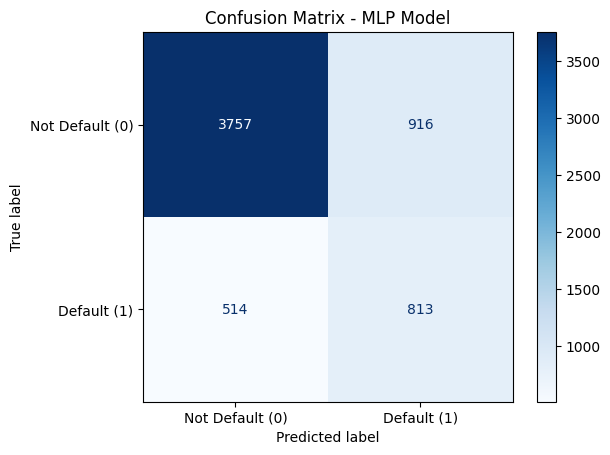

In [ ]:
# 9.5 พล็อต Confusion Matrix
print("\n--- 9.4: Confusion Matrix (MLP) ---")
cm = confusion_matrix(y_test, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Default (0)', 'Default (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MLP Model")
plt.show()



In [ ]:
# 9.6 แสดงตัวอย่าง Probability (สำหรับ Dashboard)
print("\n--- 9.5: Sample Probabilities (for Dashboard) ---")
print("    P(Default)")
print(y_proba_mlp[:10])


--- 9.5: Sample Probabilities (for Dashboard) ---
    P(Default)
[[0.41342723]
 [0.44733122]
 [0.4114884 ]
 [0.41342503]
 [0.22411157]
 [0.58847475]
 [0.2779229 ]
 [0.23825668]
 [0.3180632 ]
 [0.32733512]]
